# Kinematics
---

![](https://bhairavmehta95.github.io/static/teaching/FavSlide.png)


---



**Differential Drive** is how we model our Duckiebots - it's a two-wheeled drive system where each wheel has its own, independent actuator (or in our case, a motor).



#### Q: How Do We Determine Motion in Differential Drive Systems?

Through differences in wheel angular velocities, $\dot\phi_{l/r}$

#### Our goal: Build a model such that, given voltage as input, delivers a pose as output.

![](https://bhairavmehta95.github.io/static/teaching/Kin.png)

---

As we saw in class, this has to go through quite a few steps. From voltages, we go to torques, and after passing them through our dynamics model, we get accelerations and velocities. From there, we can simply use our kinematic model to output our position and orientation.

#### Differential Drive Code
For now, we will give you the differential drive code. We will derive it in a later part of the instructional, so don't peek!

In [27]:
# Graciously taken from the hard work of @maximecb. 
# Also, if you're reading this, You've Cheated :( 

# Used later
!wget "https://bhairavmehta95.github.io/static/teaching/dt.png"

import math
import numpy as np
import matplotlib.pyplot as plt

def plot_poses(poses, draw_line=False):
    coords = np.array([p[0] for p in poses])
    xmin = np.min(coords[:, 0])
    xmax = np.max(coords[:, 0])
    ymin = np.min(coords[:, 1])
    ymax = np.max(coords[:, 1])
    
    plt.axis([xmin - 0.1, xmax + 0.1, ymin - 0.1, ymax + 0.1])
    for i, p in enumerate(poses):
        x = p[0][0]
        y = p[0][1]
        angle = p[1]
        
        if i == 0:
            plt.arrow(x, y, 0.001 * math.cos(angle), 0.001 * math.sin(angle),
                 head_width=0.05, head_length=0.08,
                  fc='r', ec='r')
        else:
            plt.arrow(x, y, 0.001 * math.cos(angle), -0.001 * math.sin(angle),
                 head_width=0.05, head_length=0.08,
                  fc='k', ec='k')
            
    if draw_line:
        plt.hlines(0, 0, xmax, linestyles='dashed', colors='r')


def rotate_point(px, py, cx, cy, theta):
    """
    Rotate a 2D point around a center
    """

    dx = px - cx
    dy = py - cy

    new_dx = dx * math.cos(theta) + dy * math.sin(theta)
    new_dy = dy * math.cos(theta) - dx * math.sin(theta)

    return cx + new_dx, cy + new_dy
  
def get_dir_vec(angle):
    """
    Vector pointing in the direction the agent is looking
    """

    x = math.cos(angle)
    y = -math.sin(angle)
    return np.array([x, y])

def get_right_vec(angle):
    """
    Vector pointing to the right of the agent
    """

    x = math.sin(angle)
    y = math.cos(angle)
    return np.array([x, y])

def drive(cur_pos, cur_angle):
    """
    Drive this bad boy
    """
    cur_pos = np.array(cur_pos)
    
    Vl = left_vel
    Vr = right_vel
    l = wheel_dist

    # If the wheel velocities are the same, then there is no rotation
    if Vl == Vr:
      cur_pos = cur_pos + dt * Vl * get_dir_vec(cur_angle)
      return cur_pos, cur_angle

    # Compute the angular rotation velocity about the ICC (center of curvature)
    w = (Vr - Vl) / l
    

    # Compute the distance to the center of curvature
    r = (l * (Vl + Vr)) / (2 * (Vl - Vr))

    # Compute the rotation angle for this time step
    rotAngle = w * dt

    # Rotate the robot's position around the center of rotation
    r_vec = get_right_vec(cur_angle)
    px, py = cur_pos
    cx = px + r * r_vec[0]
    cy = py + r * r_vec[1]
    npx, npy = rotate_point(px, py, cx, cy, rotAngle)
    cur_pos = np.array([npx, npy])
   
    # Update the robot's direction angle
    cur_angle += rotAngle
    return cur_pos, cur_angle


Redirecting output to ‘wget-log.4’.


#### Your Turn!

Now, we are going to drive our simulated Duckiebot.

Play with the parameters above (sliders), and below in the Python code, and watch the plot. How does your Duckiebot drive change with larger differences in velocity? **(Easy)** How does your Duckiebot drive change as a function of `dt` and  `wheel_dist`? **(Harder)**

The red arrow is where you start, and you can watch your agent progress, plotted at each time step.

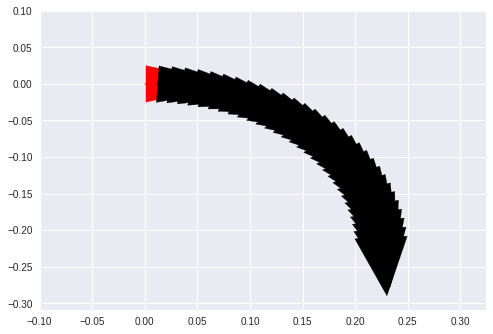

In [72]:
#@title Parameters { run: "auto" }

left_vel = 0 #@param {type:"slider", min:-1, max:1, step:0.05}
right_vel = 0.05 #@param {type:"slider", min:-1, max:1, step:0.05}
wheel_dist = 0.45 #@param {type:"slider", min:0.1, max:1, step:0.05}
dt = 0.45 #@param {type:"slider", min:0.25, max:1, step:0.05}
total_timesteps = 30 #@param {type:"slider", min:10, max:100, step:10}

start_pos = [0, 0]

cur_pos = start_pos
cur_angle = 0

poses = [(cur_pos, cur_angle)]

for t in range(total_timesteps):
    cur_pos, cur_angle = drive(cur_pos, cur_angle)
    poses.append((cur_pos, cur_angle))
    
plot_poses(poses)
    

## Assumptions

As we start to write our own differential drive code, it's worth the time to go over what assumptions we are making as we write it.

![](https://bhairavmehta95.github.io/static/teaching/Geom.png)

#### On the Geometric Side, We Assume:
1. Identical wheels (both have a radius $R$)
2. Our wheels are equally spaced from the center, with an axle length of $2L$
3. Our Duckiebot is Symmetric along the Longitudinal Axis
4. Our Center of Mass is on the Symmetry Axis

#### On the Kinematic Side, We Assume:
1. We have a rigid body
2. There is no lateral slipping
3. We have pure rolling

#### In Addition, for Sake of Simplicity, We Choose Not to Model:
1. The Castor Wheel
2. Out of plane dynamics
3. Friction

(and thereby, their effect on our motion model)



## Writing A Differential Drive Robot

Now that everything's on the table, we can get started.
 
We will call our function `drive()`, and will provide to it:

1. The left and right wheel velocities
2. The current position, and the current angle (Our drive function will compute deltas to both of these, and update them accordingly)
3. Parameters: wheel distance, `dt` (How long we are integrating the velocity for)

Now, our function header for drive looks like this:

```
drive(left_vel, right_vel, cur_pos, cur_angle, wheel_dist, dt):
    # Magic
```

We can take care of the simplest case first. If `left_vel` is equal to `right_vel`, we will not have any 
rotation during our integration, and our updated position simply becomes:

```
if left_vel == right_vel:
    cur_pos = cur_pos + dt * Vl * get_dir_vec(cur_angle)
```

where `get_dir_vec()` just returns a heading in the robot's forward facing direction. Remember, we're working in two dimensions!

But, what happens if:

```
if left_vel != right_vel:
    ¯\_(ツ)_/¯
```

Now, we need to use all of the things we learned in class!



#### Computing the Rotation

We will tackle the rotation. 

We now need to compute an angular velocity, which is nonzero since our wheel velocities are not equal. We compute this around the Instantaneous Centre of Curvature (ICC) as follows:

``` 
omega = (left_vel - right_vel) / wheel_dist
```

Which we can use to compute the rotation angle for this timestep (We assume it stays constant throughout the entire duration `dt`).

```
rotAngle = w * dt
```
    
Given a vector orthogonal to the heading, `r_vec`, we now need to rotate the robot around its center of rotation, which will give us our new position as well.

We first compute the distance to the center of curvature:

```
dist_cc = (l * (Vl + Vr)) / (2 * (Vl - Vr))
```

From here, we compute the new x and y coordinates of our robot, as follows

 ```
px, py = cur_pos
cx = px + dist_cc * r_vec[0]
cy = py + dist_cc * r_vec[1]
npx, npy = rotate_point(px, py, cx, cy, rotAngle)
cur_pos = np.array([npx, npy])
```

And there you have it! Feel free to pop open that earlier code tab, and you'll see what drives our simulated Duckiebot in `gym-duckietown`.



#### Q: Can we do better than a differential drive model? Is it worth it?

Of course! As we've gone over, modeling a true autonomous vehicle will require much more complex modeling. Luckily, our Duckiebots have little mass (which allow us to forgo many dynamics properties that cannot be ignored in a real autonomous system), and have many other properties that make it easy to model relatively well.

In fact, differential drive models are great for exactly that reason: they are easy to model **and** program (as we've just seen), and they can be well controlled. 

## An example:

#### Differential Drive Driving Duckiebots



![](https://bhairavmehta95.github.io/static/teaching/dd-drive.gif =250x)

# Calibration

Hooray! You've built a working differential drive robot (All of robotics is usually executed on 2D Python plots, so we're done!)

As you'll soon see, if not already, all robots are not made the same, which is especially true for your Duckiebots.

In order to get them road ready, you will need to **calibrate** your robot. Simply, we need to find **parameters** for your models in order to make sure they do what you think they will do. This is true for camera parameters, as well as odometry parameters - in this Instructional, we will focus only on the latter. We will start with encoder-based calibration.



#### Q: Where are the Duckiebot's wheel encoders?




There are none!

## Odometry Calibration

As we've seen in lecture, we cannot do encoder-based calibration for obvious reasons. Instead, we will perform a simpler odometry calibration, which we can simulate in this Instructional.

We need to find two parameters, the **gain** and the **trim**. The gain can be thought of as the amplification, where as the trim can be thought of as alignment. Even more intuitively, we can think of these two parameters compensating for differences in the two motors. 

With these, we can define our simple odometry calibration model for our Duckiebots:

```
left_vel = (gain + trim)*(vel_actual - omega * wheel_dist)
right_vel = (gain - trim)*(vel_actual - omega * wheel_dist)
```

Using this, we will simulate the actual odometry calibration procedure. As before, we encourage you to play around with this code, and try to see how different parameter settings affect your results.



### Basic Odometry Calibration for Duckietown

We will use the a slightly modified calibration setup as presented in class.

While  $\Delta$  > 5cm:

1. Set Gain to mininize slipping of wheels (`gain ~ 1`)
2. Drive Duckiebot forward on straight line for 1 meters.
3. Adjust Trim

Where  $\Delta$ is the perpendicular distance from where your Duckiebot ends up and the actual straight line.

If you have a left drift, you'll want to **increase** `trim`; if right, you'll want to **decrease** it.

Below you'll find the code we'll use to actually drive our robot, which now takes a velocity and angle, rather than wheel velocities (which get calculated internally). The parameters hardcoded in there need not be changed, but feel free to experiment with them after you find a good set of calibration parameters, to see if your results still hold.


In [0]:
def calibrate_drive(cur_pos, cur_angle, gain, trim, radius, k_l, k_r, vel, dt, seed):
    angle = 0
    limit = 1
       
    # Comment these next five lines if you want to make it easier!
    np.random.seed(seed)
    wheel_dist = np.random.uniform(0.25, 0.35)
    radius = np.random.uniform(radius - 0.01, radius + 0.01)
    k_l = k_r = np.random.uniform(k_l - 1.0, k_l + 1.0)
    gain = np.random.normal(gain, max(0.1, np.abs(gain) * 0.10))
    trim = np.random.normal(trim, max(0.03, np.abs(trim) * 0.10))

    # adjusting k by gain and trim
    k_r_inv = (gain + trim) / k_r
    k_l_inv = (gain - trim) / k_l

    omega_r = (vel + 0.5 * cur_angle * wheel_dist) / radius
    omega_l = (vel - 0.5 * cur_angle * wheel_dist) / radius

    # conversion from motor rotation rate to duty cycle
    u_r = omega_r * k_r_inv
    u_l = omega_l * k_l_inv

    # limiting output to limit, which is 1.0 for the duckiebot
    u_r_limited = max(min(u_r, limit), -limit)
    u_l_limited = max(min(u_l, limit), -limit)

    # If the wheel velocities are the same, then there is no rotation
    if u_l_limited == u_r_limited:
        cur_pos = cur_pos + dt * u_l_limited * get_dir_vec(cur_angle)
        return cur_pos, cur_angle

    # Compute the angular rotation velocity about the ICC (center of curvature)
    w = (u_r_limited - u_l_limited) / wheel_dist  

    # Compute the distance to the center of curvature
    r = (wheel_dist * (u_l_limited + u_r_limited)) / (2 * (u_l_limited - u_r_limited))
    
    # Compute the rotation angle for this time step
    rotAngle = w * dt

    # Rotate the robot's position around the center of rotation
    r_vec = get_right_vec(cur_angle)
    px, py = cur_pos
    cx = px + r * r_vec[0]
    cy = py + r * r_vec[1]
    npx, npy = rotate_point(px, py, cx, cy, rotAngle)
    cur_pos = np.array([npx, npy])
   
    # Update the robot's direction angle
    cur_angle += rotAngle
    return cur_pos, cur_angle

def calculate_delta(poses):
    end = poses[-1][0]
    
    return end[1]

### Calibrating your Duckiebot:

Have fun!

Remember, `k` is the intrinsic motor parameter. You need not change it (it's default value is `TODO` if you change it), but if you'd like you can experiment with it, and see what happens when `k_r` and `k_l` are different.

You'll see that we randomized it a bit, so that we don't all end up with trivial solutions.

Before you start, you should pick a number (ideally, a unique one) and set it as `seed`. This will let you play around with the gain and trim parameters uniquely.

-0.4056468011371596

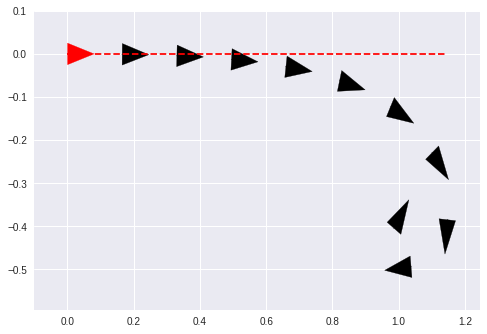

In [30]:
#@title Calibration Parameters { run: "auto" }

gain = 1 #@param {type:"slider", min:0.8, max:1.2, step:0.05}
trim = -0.039 #@param {type:"slider", min:-0.05, max:0.05, step:0.001}

# Change these here if you want to really make life difficult!
radius = 0.0318
k = 27
k_l = k
k_r = k


# Starting params, do not change.
vel = 0.2
dt = 0.5

# Pick a number, any number!
seed = 10

total_timesteps = int(1.0 / (vel * dt))
start_pos = [0, 0]
cur_pos = start_pos
cur_angle = 0

poses = [(cur_pos, cur_angle)]

for t in range(total_timesteps):
    cur_pos, cur_angle = calibrate_drive(cur_pos, cur_angle, gain, trim, radius, k_l, k_r, vel, dt, seed)
    poses.append((cur_pos, cur_angle))
   
plot_poses(poses, draw_line=True)
calculate_delta(poses)

## Extra Challenge: A Left Turn

Found a good set of parameters? Below you'll see some code that will execute a set of actions on a selected part of Duckietown, particularly a right turn. After tuning your gain and trim is that, try to find a set of actions that will execute a left turn on our image of Duckietown below.

Give it a shot!



[([2.5, 2.5], 0), (array([3.3241705 , 2.47686021]), 0.0561381755585732), (array([4.12997666, 2.31356839]), 0.3437350476669808), (array([4.48525523, 1.64809757]), 1.8170989399480924), (array([4.38416803, 1.56431739]), 9.365168371869725)]


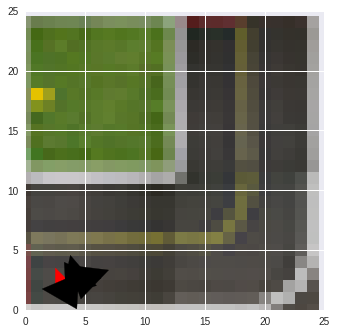

In [62]:
def plot_poses_challenge(poses):
    from PIL import Image
    import PIL
    img = Image.open('dt.png').resize((25, 25), resample=PIL.Image.LANCZOS)
    img = np.rot90(np.array(img, dtype=np.uint8), 3) 
    
    fig, ax = plt.subplots()
    plt.imshow(img)
    
    coords = np.array([p[0] for p in poses])

    plt.axis([0, 25, 0, 25])
    for i, p in enumerate(poses):
        x = p[0][0]
        y = p[0][1]
        angle = p[1]
        
        if i == 0:
            plt.arrow(x, y, 0.00001 * math.cos(angle), 0.00001 * math.sin(angle),
                 head_width=2, head_length=1,
                  fc='r', ec='r')
        else:
            plt.arrow(x, y, 0.001 * math.cos(angle), 0.001 * math.sin(angle),
                 head_width=3, head_length=3,
                  fc='k', ec='k')

cur_pos = [2.5, 2.5]
cur_angle = 0

vels = [(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0)] # TODO: Find this!
poses = [(cur_pos, cur_angle)]

for v in vels:
    cur_pos, cur_angle = calibrate_drive(cur_pos, cur_angle, gain, trim, radius, k_l, k_r, vel, dt * 5, seed)
    poses.append((cur_pos, cur_angle))


plot_poses_challenge(poses)
            

    

